In [1]:
from datetime import datetime
import matplotlib.pylab as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import stor
import sys
from scipy import stats

In [2]:
# For each sequencer, read in basic_stats_human files and manifests and combine
df_iseq = pd.read_csv("/Users/rchin/Downloads/batch_basic_stats.basic_stats_human_iseq.csv")
df_ibc = pd.read_csv("/Users/rchin/Downloads/BPA73020-2824.manifest_clean 4.5.csv")
df_hiseq= pd.read_csv("/Users/rchin/Downloads/batch_basic_stats.basic_stats_human_hiseq4k.csv")
df_hbc = pd.read_csv("/Users/rchin/Downloads/H53HGBBXY.manifest_clean 4.8.csv")

# Merge iSeq samplesheet with iSeq qc metrics
df_icombine = pd.merge(df_ibc, df_iseq, on="sample")
# Fix typo in loc[141] from 'IPS_XY_Pooled_IPS_CLN_RCSET_D10' to 'IPS_XY_Pooled_IPS_CLN_RCSET2_D10'
df_icombine.at[141,'sample'] = 'IPS_XY_Pooled_IPS_CLN_RCSET2_D10'

# Merge hiseq samplesheet with hiseq qc metrics
df_hcombine = pd.merge(df_hbc, df_hiseq, on="sample")

# consolidate sample sheet to one lane
df_hcombine1 = df_hcombine[df_hcombine['lane'] == 1]

# read in all_barcodes.html files for iSeq/HiSeq
df_all_bc_iseq = pd.read_csv('/Users/rchin/Downloads/iSeq_all_barcodes.html.csv')
df_all_bc_hiseq= pd.read_csv('/Users/rchin/Downloads/HiSeq_all_barcodes.html.csv')

In [3]:
# merge iSeq and HiSeq QC Metrics/samplesheet
# df_icombine1 = pd.read_csv('/Users/rchin/Downloads/BPA73020-2824.combine spar3404.csv')
        #fixed typo in icombine.loc[141]
df_merge = pd.merge(df_hcombine1,df_icombine, on="sample", suffixes=('_hiseq', '_iseq'), how='outer', indicator=True)

# Remove failed wells (wells that did not get consolidated [406,161,654]
df_merge = df_merge.drop([406,161,654]).reset_index()

In [171]:
# Collect linear regression statistics:
slope, intercept, r_value, p_value, std_err =\
    stats.linregress(df_merge.total_mapped_reads_iseq, df_merge.total_mapped_reads_hiseq)
print ('trendline:', slope,'x +', intercept)
print ('r-squared:',r_value**2)

# Calculate Cv for iSeq and HiSeq mapped reads
cv_i = stats.variation(df_merge.total_mapped_reads_iseq)
cv_h = stats.variation(df_merge.total_mapped_reads_hiseq)
print ("iseqCV =", cv_i, "hiseqCV =", cv_h)

trendline: 703.9727373076794 x + 209050.22838763148
r-squared: 0.9060706841590882
iseqCV = 0.19549006989536202 hiseqCV = 0.1906440514026765


In [5]:
# Function to calculate residual
def y_distance(x1, y1, a, c):
    y_d = y1 - (a * x1 + c)
    return y_d

In [6]:
# To add column for residual values (y-axis distance from point to trendline) using linregress slope/intercept
residual_series = pd.Series()
for i, row in df_merge.iterrows():
    residual = pd.Series([y_distance(row.total_mapped_reads_iseq, row.total_mapped_reads_hiseq, slope, intercept)])
    residual_series = residual_series.append(residual, ignore_index=True)

In [7]:
#add residual and percent residual(percent change required to get point to trend line.)
df_merge['residual'] = residual_series  #residual is y-distance
df_merge['abs_residual'] = abs(df_merge['residual'])
# df_merge['cv_residual'] = stats.variation(df_merge.residual)
df_merge['pct_residual'] = (residual_series / df_merge.total_mapped_reads_hiseq * -1)
df_merge['abs_pct_residual'] = abs(df_merge['pct_residual'])

# Sort by abs_pct_residual, high-to-low
df_merge = df_merge.sort_values(by=['abs_pct_residual'], ascending=False)
# print (df_merge.head())

In [11]:
def linregress_all_metrics(df, x, metrics):
#     slope, intercept, r_value, p_value, std_err =\
#     stats.linregress(df_merge.total_mapped_reads_iseq, df_merge.total_mapped_reads_hiseq)
# print ('trendline:', slope,'x +', intercept)
# print ('r-squared:',r_value**2)

    df_stats = pd.DataFrame()
    statistics = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

    for metric in metrics:
        test = x
        ref = metric
        df_tmp = pd.DataFrame(columns=statistics)
        series_stat = pd.Series(stats.linregress(df[ref], df[test]), index=statistics)
        df_tmp = df_tmp.append(series_stat, ignore_index=True)
        df_tmp['comparison'] = x
        df_tmp['metric'] = metric
        df_tmp['r_squared'] = df_tmp.r_value**2

        df_stats = pd.concat([df_tmp, df_stats])

    df_stats = df_stats.reset_index(drop=True)
    return df_stats


In [183]:
#Generate table to perform linear regression analysis of one metric against a series of metrics.

comparison = 'pct_residual'
metrics_shortlist = ['total_mapped_reads_pre_dedupe_hiseq', 'total_mapped_reads_hiseq',
                     'total_unmapped_reads_hiseq', 'duped_reads_hiseq', 'ILMN_adapters_hiseq',
                     'library_complexity_hiseq','reads_aligned_at_duped_pos_hiseq', 'proximal_dup_rate_hiseq',
                     'max_contamination_hiseq']

all_hiseq = ['total_mapped_reads_pre_dedupe_hiseq', 'total_mapped_reads_hiseq',
       'total_unmapped_reads_hiseq', 'ILMN_adapters_hiseq',
       'duped_reads_hiseq', 'mapped_freq_hiseq', 'unmapped_freq_hiseq',
       'library_complexity_hiseq', 'Q30_hiseq', 'Q20_hiseq',
       'contamination_hiseq', 'reads_aligned_at_duped_pos_hiseq',
       'proximal_dup_reads_hiseq', 'proximal_dup_rate_hiseq',
       'max_contamination_hiseq', 'total_contamination_hiseq', 'hiseq_avg_pct_perfect_bc']

all_iseq = ['total_mapped_reads_pre_dedupe_iseq', 'total_mapped_reads_iseq',
       'total_unmapped_reads_iseq', 'ILMN_adapters_iseq', 'duped_reads_iseq',
       'mapped_freq_iseq', 'unmapped_freq_iseq', 'library_complexity_iseq',
       'Q30_iseq', 'Q20_iseq', 'contamination_iseq',
       'reads_aligned_at_duped_pos_iseq', 'proximal_dup_reads_iseq',
       'proximal_dup_rate_iseq', 'max_contamination_iseq',
       'total_contamination_iseq']

# Collect regression stats of top-## abs_pct_residual and analyze correllation with metrics.
# df_stats = linregress_all_metrics(df_merge.sort_values(by=['abs_pct_residual'], ascending=False).head(8),
#                                   comparison, all_hiseq)
# print (df_stats.sort_values(by=['r_squared'], ascending=False))

# Create subset of samples with high abs_pct_residual values to analyze correllation.
df_deviate = df_merge_bc[df_merge_bc['abs_pct_residual'] > 0.125]
df_stats1 = linregress_all_metrics(df_deviate, comparison, all_hiseq)
display(df_stats1.sort_values(by=['r_squared'], ascending=False))
print('n = ', len(df_deviate))

,slope,intercept,r_value,p_value,std_err,comparison,metric,r_squared
9,1.703365e+01,-14.823002,0.915886,1.362957e-10,1.556761e+00,pct_residual,library_complexity_hiseq,0.838847
0,-2.593349e+00,2.432895,-0.873691,1.181120e-08,3.010968e-01,pct_residual,hiseq_avg_pct_perfect_bc,0.763335
8,3.642808e+01,-35.388966,0.852118,6.482477e-08,4.665145e+00,pct_residual,Q30_hiseq,0.726105
3,-2.047223e+01,1.331356,-0.846777,9.483065e-08,2.681643e+00,pct_residual,proximal_dup_rate_hiseq,0.717032
7,9.901315e+01,-97.947530,0.839220,1.586348e-07,1.337783e+01,pct_residual,Q20_hiseq,0.704291
10,-1.093049e+01,1.059430,-0.753222,1.388847e-05,1.990327e+00,pct_residual,unmapped_freq_hiseq,0.567343
11,1.093049e+01,-9.871063,0.753222,1.388847e-05,1.990327e+00,pct_residual,mapped_freq_hiseq,0.567343
14,-1.459981e-06,0.451599,-0.588876,1.955186e-03,4.178217e-07,pct_residual,total_unmapped_reads_hiseq,0.346775
4,-2.017070e-06,0.447115,-0.571410,2.847773e-03,6.040524e-07,pct_residual,proximal_dup_reads_hiseq,0.326510
5,-3.718165e-07,0.452275,-0.566339,3.164226e-03,1.128252e-07,pct_residual,reads_aligned_at_duped_pos_hiseq,0.320740


n =  25


In [185]:
df_deviate.head(15)
# df_stats.head(15)
print (df_stats1[['metric','r_squared']].sort_values(by=['r_squared'], ascending=False))
df_stats2 = linregress_all_metrics(df_merge.sort_values(by=['abs_pct_residual'], ascending=False).head(2),
                                   comparison, all_hiseq)
# df_stats2 = df_stats2.rename(columns = {'r_squared':'r_squared2'})
df_stats3 = linregress_all_metrics(df_merge.sort_values(by=['abs_pct_residual'], ascending=False).head(3),
                                   comparison, all_hiseq)

df_stats_merge = pd.concat([df_stats2, df_stats3], keys=['metric'])
display(df_stats_merge)

                                 metric  r_squared
9              library_complexity_hiseq   0.838847
0              hiseq_avg_pct_perfect_bc   0.763335
8                             Q30_hiseq   0.726105
3               proximal_dup_rate_hiseq   0.717032
7                             Q20_hiseq   0.704291
10                  unmapped_freq_hiseq   0.567343
11                    mapped_freq_hiseq   0.567343
14           total_unmapped_reads_hiseq   0.346775
4              proximal_dup_reads_hiseq   0.326510
5      reads_aligned_at_duped_pos_hiseq   0.320740
13                  ILMN_adapters_hiseq   0.315515
12                    duped_reads_hiseq   0.233858
16  total_mapped_reads_pre_dedupe_hiseq   0.108895
15             total_mapped_reads_hiseq   0.089795
2               max_contamination_hiseq   0.080428
6                   contamination_hiseq   0.011580
1             total_contamination_hiseq   0.011580


KeyError: 'hiseq_avg_pct_perfect_bc'

In [130]:
comparison = 'pct_residual'
def rsquared(df, x, metrics, limit):

    df_rsquared = pd.DataFrame()

    for num in range(2,limit):
        df_tmp = pd.DataFrame()
        df_tmp = linregress_all_metrics(df.sort_values(by=[x], ascending=False).head(num),
                                   x, metrics)
        df_tmp['num'] = num
        df_tmp[x] = df.sort_values(by=['abs_pct_residual'], ascending=False).reset_index().loc[num-2][x]
        df_rsquared = pd.concat([df_tmp, df_rsquared], sort=False)
    
    return df_rsquared

In [131]:
# m, b, r_value, p_value, stderr = stats.linregress(df_merge[comparison], df_merge['max_contamination_hiseq'])
statistics = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
series_stat = pd.Series(stats.linregress(df_merge[comparison], df_merge['max_contamination_hiseq']), index=statistics)
print (series_stat['r_value'])

-0.08280937015694724


In [134]:
# df_stats[df_stats.metric == 'total_contamination_hiseq'].r_squared
# df_stats.set_index(df_stats['metric']).transpose().loc['r_squared']
df_rsquared = rsquared(df_merge_bc, comparison, all_hiseq,26)
# df_rsquared['num'] = df_rsquared.index
# df_rsquared
sub = ['max_contamination_hiseq','ILMN_adapters_hiseq', 'library_complexity_hiseq','total_contamination_hiseq', 'Q30_hiseq']
df_rsq_sub = df_rsquared.loc[df_rsquared['metric'].isin(sub)]

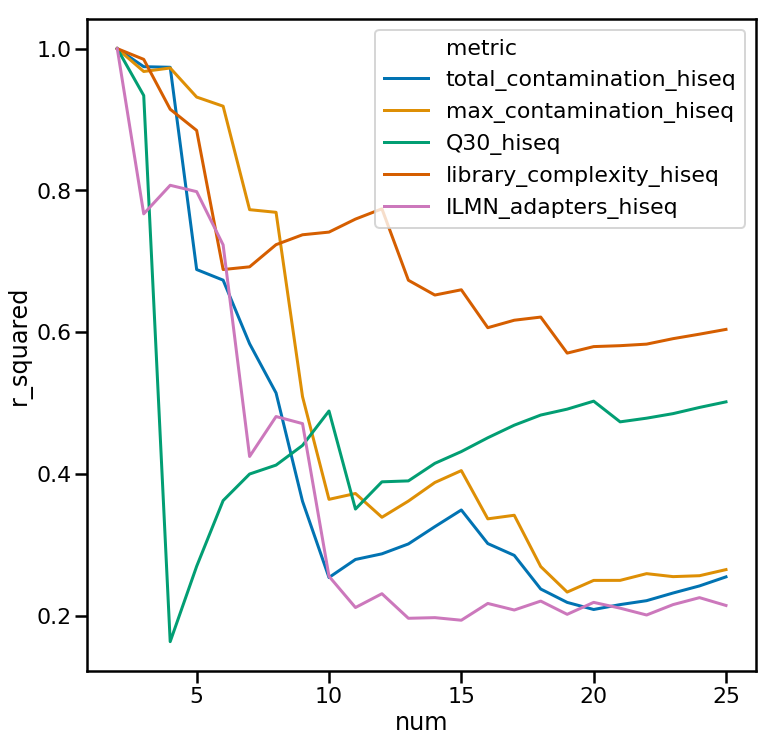

In [135]:
# Plot lineplot  with TOP-2 residuals omitted with hue for primer set
plt.figure(figsize=(12, 12))
sns.set_context("poster")
sns.lineplot(x='num', y="r_squared", hue='metric', 
             data=df_rsq_sub, palette='colorblind')
# sns.lineplot(x='num', y='abs_pct_residual', data=df_rsq_sub, palette='dark')

In [18]:
# df_merge.sort_values(by=[comparison], ascending=False).reset_index().loc[0][comparison]
# df_rsq_sub


In [19]:
# read in all_barcodes.html files for iSeq/HiSeq
df_all_bc_iseq = pd.read_csv('/Users/rchin/Downloads/iSeq_all_barcodes.html.csv')
df_all_bc_hiseq= pd.read_csv('/Users/rchin/Downloads/HiSeq_all_barcodes.html.csv')
# dftest = df_all_bc_hiseq.copy()
# dftest.head()

#convert pct columns to proper decimal format
df_all_bc_iseq.pct_perfect_barcode /= 100
df_all_bc_hiseq.pct_perfect_barcode /= 100
df_all_bc_hiseq.one_mismatch_barcode /= 100
df_all_bc_iseq.head()

,Lane,Project,Sample,iseq_barcode,iseq_comp_barcode,iseq_correct_barcode,PF_Clusters,pct_of_lane,pct_perfect_barcode,pct_one_mismatch_barcode,Yield_Mbases,pct_PF_Clusters,Q30,Mean_Quality_Score
0,1,iseq,IPS_RES_919835,ATCCATAT,TAGGTATA,ATATGGAT,"3,568",0.11,1.0,NaN,0,100.0,97.26,36.52
1,1,iseq,IPS_RES_919836,GGAGTTCA,CCTCAAGT,TGAACTCC,"5,282",0.16,1.0,NaN,0,100.0,97.55,36.58
2,1,iseq,IPS_RES_919837,CTTCAATA,GAAGTTAT,TATTGAAG,"4,447",0.14,1.0,NaN,0,100.0,97.49,36.57
3,1,iseq,IPS_RES_919838,ATCCTTCA,TAGGAAGT,TGAAGGAT,"4,292",0.13,1.0,NaN,0,100.0,97.16,36.50
4,1,iseq,IPS_RES_919839,ACTGCGCG,TGACGCGC,CGCGCAGT,"4,256",0.13,1.0,NaN,0,100.0,96.28,36.33


In [20]:
''' from hiseq all_barcode.html calculate average of pct_perfect_barcode and one_mismatch_barcode'''
''' not the most accuracte way to combine lanes, which would be to take number of 'PF clusters' into consideration,
    but average is very close as long as no individual lanes fail'''
# dftest = df_all_bc_hiseq.copy()

df_perfect_mean = df_all_bc_hiseq.groupby('barcode',as_index=False)['pct_perfect_barcode'].mean().rename(columns = {'pct_perfect_barcode':'hiseq_avg_pct_perfect_bc'})
df_mismatch_mean = df_all_bc_hiseq.groupby('barcode', as_index=False)['one_mismatch_barcode'].mean().rename(columns = {'one_mismatch_barcode':'hiseq_avg_pct_one_mismatch_bc'})

df_all_bc_hiseq = df_all_bc_hiseq.merge(df_perfect_mean, on='barcode')
df_all_bc_hiseq = df_all_bc_hiseq.merge(df_mismatch_mean, on='barcode')
df_all_bc_hiseq = df_all_bc_hiseq[df_all_bc_hiseq.Lane == 1]
print (df_all_bc_hiseq.head(10))

    Lane Project          Sample   barcode PF_Clusters  pct_of_lane  \
0      1   hiseq  IPS_RES_923655  TTCAAGCA     387,345         0.12   
8      1   hiseq  IPS_RES_923656  ATACGCAA     337,152         0.11   
16     1   hiseq  IPS_RES_923657  ACGAACCT     426,844         0.14   
24     1   hiseq  IPS_RES_923658  GTACCTAT     573,327         0.18   
32     1   hiseq  IPS_RES_923659  CGTTAATT     499,710         0.16   
40     1   hiseq  IPS_RES_923660  CTGAGCTT     421,184         0.14   
48     1   hiseq  IPS_RES_923661  CCGAATCG     429,479         0.14   
56     1   hiseq  IPS_RES_923662  GTAAGCCT     548,511         0.18   
64     1   hiseq  IPS_RES_923663  GCCTGCCG     418,720         0.13   
72     1   hiseq  IPS_RES_923664  AGAGTTAA     397,087         0.13   

    pct_perfect_barcode  one_mismatch_barcode  Yield_Mbases  pct_PF_Clusters  \
0                0.9324                0.0676            14            100.0   
8                0.9237                0.0763            1

In [21]:
'''From iseq all_barcode.html Calculate average of pct_perfect_barcode and one_mismatch_barcode'''

df_perfect_mean = df_all_bc_iseq.groupby('iseq_correct_barcode',as_index=False)['pct_perfect_barcode'].mean().rename(columns = {'pct_perfect_barcode':'iseq_avg_pct_perfect_bc'})
df_mismatch_mean = df_all_bc_iseq.groupby('iseq_correct_barcode', as_index=False)['pct_one_mismatch_barcode'].mean().rename(columns = {'pct_one_mismatch_barcode':'iseq_avg_pct_one_mismatch_bc'})

df_all_bc_iseq = df_all_bc_iseq.merge(right=df_perfect_mean, on='iseq_correct_barcode').merge(right=df_mismatch_mean, on='iseq_correct_barcode')

df_all_bc_iseq = df_all_bc_iseq[df_all_bc_iseq.Lane == 1]
print (df_all_bc_iseq.head(10))

   Lane Project          Sample iseq_barcode iseq_comp_barcode  \
0     1    iseq  IPS_RES_919835     ATCCATAT          TAGGTATA   
1     1    iseq  IPS_RES_919836     GGAGTTCA          CCTCAAGT   
2     1    iseq  IPS_RES_919837     CTTCAATA          GAAGTTAT   
3     1    iseq  IPS_RES_919838     ATCCTTCA          TAGGAAGT   
4     1    iseq  IPS_RES_919839     ACTGCGCG          TGACGCGC   
5     1    iseq  IPS_RES_919840     TGGTAGGA          ACCATCCT   
6     1    iseq  IPS_RES_919841     ATAGGTAC          TATCCATG   
7     1    iseq  IPS_RES_919842     GCGGTTGC          CGCCAACG   
8     1    iseq  IPS_RES_919843     CCGAGCTC          GGCTCGAG   
9     1    iseq  IPS_RES_919844     CATTGGTT          GTAACCAA   

  iseq_correct_barcode PF_Clusters  pct_of_lane  pct_perfect_barcode  \
0             ATATGGAT       3,568         0.11                  1.0   
1             TGAACTCC       5,282         0.16                  1.0   
2             TATTGAAG       4,447         0.14          

In [22]:
'''Add avg_pct_perfect_bc from hiseq and iseq to df_merge and export'''
df_merge_bc = df_merge.merge(df_all_bc_hiseq[['barcode','hiseq_avg_pct_perfect_bc','hiseq_avg_pct_one_mismatch_bc']],
         left_on='barcode_hiseq', right_on='barcode').merge(df_all_bc_iseq[['iseq_correct_barcode','iseq_avg_pct_perfect_bc','iseq_avg_pct_one_mismatch_bc']],
         left_on='barcode_hiseq', right_on='iseq_correct_barcode')
#replace plate_coor names with ips_index
df_merge_bc['plate_coor'] = df_merge_bc['unique_id_x_hiseq'].str.replace('IPS_CLN_RCSET','IPS_indexSet_').str.replace('a','').str.replace('b','')

# df_merge_bc['plate_coor'] = df_merge_bc['plate_coor'].replace("IPS_CLN_RCSET","IPS_indexSet_", inplace=True).replace('a','', inplace=True).replace('b','', inplace=True)

# print (df_merge_bc.head())
bc_summary = ['index', 'barcode', 'plate_coor', 'residual', 'abs_residual', 'pct_residual', 
           'abs_pct_residual', 'hiseq_avg_pct_perfect_bc', 'hiseq_avg_pct_one_mismatch_bc','iseq_avg_pct_perfect_bc',
             'iseq_avg_pct_one_mismatch_bc']
df_merge_bc_summary = df_merge_bc[bc_summary]

display(df_merge_bc_summary.head())
# df_merge_bc.to_csv("/Users/rchin/Downloads/iseq_hiseq_merge_bc_4.24.csv")
# df_merge_bc_summary.to_csv("/Users/rchin/Downloads/iseq_hiseq_bc_summary_4.24.csv")


,index,barcode,plate_coor,residual,abs_residual,pct_residual,abs_pct_residual,hiseq_avg_pct_perfect_bc,hiseq_avg_pct_one_mismatch_bc,iseq_avg_pct_perfect_bc,iseq_avg_pct_one_mismatch_bc
0,116,AGAAGTCT,IPS_indexSet_2_B10,-1.541255e+06,1.541255e+06,0.913535,0.913535,0.579912,0.420088,1.0,NaN
1,204,AGAATCGG,IPS_indexSet_3_B01,-9.128022e+05,9.128022e+05,0.499417,0.499417,0.737025,0.262975,1.0,NaN
2,208,AGATAGGC,IPS_indexSet_3_B05,-7.057571e+05,7.057571e+05,0.375000,0.375000,0.805088,0.194913,1.0,NaN
3,37,CCTCCGAG,IPS_indexSet_1_D02,-8.016849e+05,8.016849e+05,0.363816,0.363816,0.772663,0.227337,1.0,NaN
4,25,CAGCCGGC,IPS_indexSet_1_C02,-7.684736e+05,7.684736e+05,0.291852,0.291852,0.938412,0.061587,1.0,NaN


In [155]:
# create a pandas series to compare two qc metrics
# m, b, r_value, p_value, stderr = stats.linregress(df_merge_bc_summary[comparison],
                                # df_merge_bc_summary['hiseq_avg_pct_perfect_bc']))
statistics = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
series_stat = pd.Series(stats.linregress(df_merge_bc['library_complexity_hiseq'].head(25), 
                                         df_merge_bc['hiseq_avg_pct_perfect_bc'].head(25)), index=statistics)
print ('r-squared:', series_stat['r_value']**2)

r-squared: 0.5899648443377254


In [24]:
'''Plot r_squared correlation between abs_pct_residual and hiseq_avg_pct_perfect_bc'''
df_bc_rsqd = rsquared(df_merge_bc_summary, comparison, ['hiseq_avg_pct_perfect_bc'], 500)#len(df_merge_bc_summary))
# Plot lineplot with r-squared values vs number of samples included in correlation analysis
ax = plt.figure(figsize=(12, 12))
sns.set_context("poster")
# ax = sns.lineplot(x='num', y="r_squared", data=df_bc_rsqd, palette='colorblind')

# ax.set_title('High Correlation Between Abs. Residual% and Barcode Read Accuracy')





<Figure size 864x864 with 0 Axes>

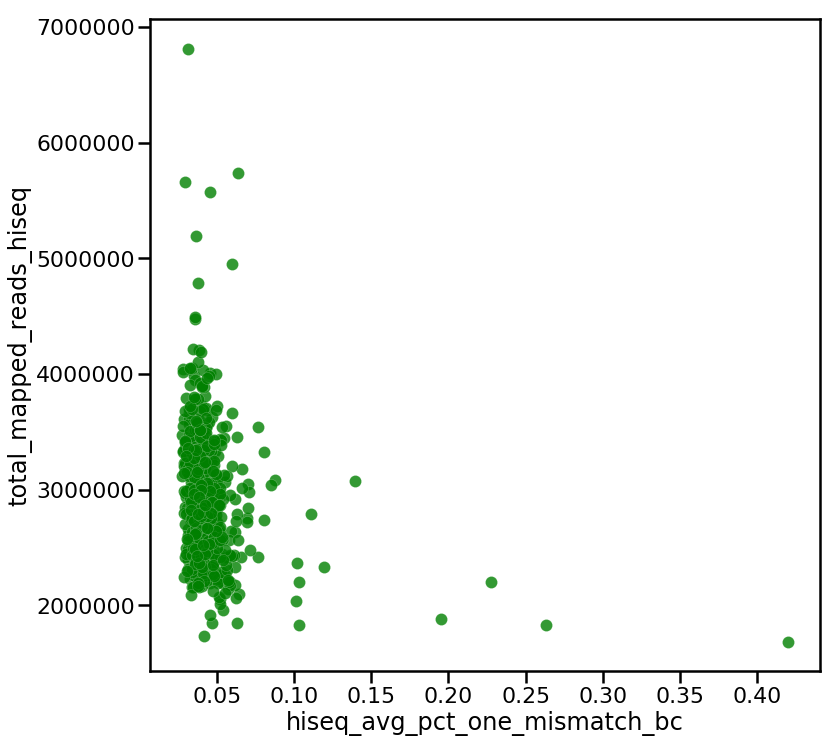

In [25]:
plt.figure(figsize=(12, 12))
sns.set_context("poster")

# ax = sns.scatterplot(x=df_merge_bc.hiseq_avg_pct_perfect_bc*100,
#                      y=df_merge_bc.abs_pct_residual*100, alpha=0.8, linewidth=0.2, color='teal',
#              data=df_merge_bc.sort_values(by='hiseq_avg_pct_perfect_bc', ascending=True).tail(631))

# ax.set_title('Variation of Abs. %Residual in 95th-Percentile Performing Barcodes')
# ax.set_xlabel('Average Percent Perfect Barcode')
# ax.set_ylabel('Absolute Percent Residual')

ax = sns.scatterplot(x=df_merge_bc.hiseq_avg_pct_one_mismatch_bc,
                     y=df_merge_bc.total_mapped_reads_hiseq, alpha=0.8, linewidth=0.2, color='green',
                     data=df_merge_bc.sort_values(by='hiseq_avg_pct_one_mismatch_bc', ascending=False))

plt.show()

# ax.figure.savefig("/Users/rchin/Downloads/Barcode_v_mapped_4.29.png", bbox_inches = 'tight')


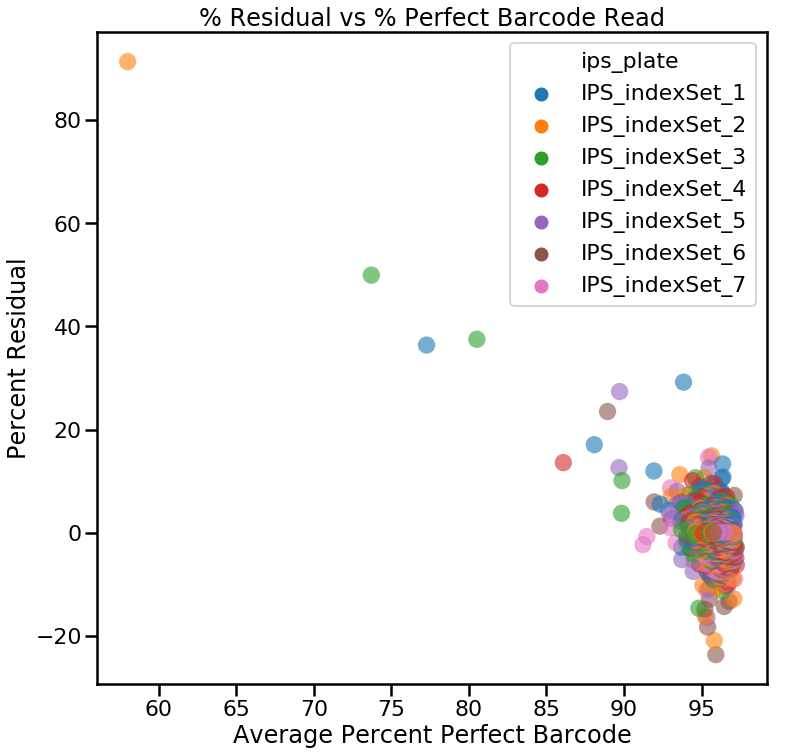

In [34]:
'''scatter plot of avg percent perfect barcode vs absolute percent residual'''
plate_order=['IPS_indexSet_1','IPS_indexSet_2', 'IPS_indexSet_3', 'IPS_indexSet_4', 'IPS_indexSet_5',
            'IPS_indexSet_6', 'IPS_indexSet_7']

plt.figure(figsize=(12, 12))
sns.set_context("poster")

ax = sns.scatterplot(x=df_merge_bc.hiseq_avg_pct_perfect_bc*100, s=300, 
                     y=df_merge_bc.pct_residual*100, alpha=0.6, linewidth=0, #color='teal',
             data=df_merge_bc.sort_values(by='hiseq_avg_pct_perfect_bc', ascending=True), 
                     hue='ips_plate',hue_order=plate_order)

ax.set_title('% Residual vs % Perfect Barcode Read')
ax.set_xlabel('Average Percent Perfect Barcode')
ax.set_ylabel('Percent Residual')

plt.show()

# ax.figure.savefig("/Users/rchin/Downloads/pctResidual_v_PerfectBC_4.30.png", bbox_inches = 'tight')

In [28]:
# print ('Abs Pct Residual CV =', stats.variation(df_merge_bc_summary.sort_values(by='hiseq_avg_pct_perfect_bc', ascending=True).tail(500).abs_pct_residual))
print ('Abs Pct Residual CV =', stats.variation(df_merge_bc_summary.tail(655).residual))
print ('Avg Pct Perfect Barcode CV = ', stats.variation(df_merge_bc_summary.hiseq_avg_pct_perfect_bc))


Abs Pct Residual CV = 19.92964363987464
Avg Pct Perfect Barcode CV =  0.02345987049592718


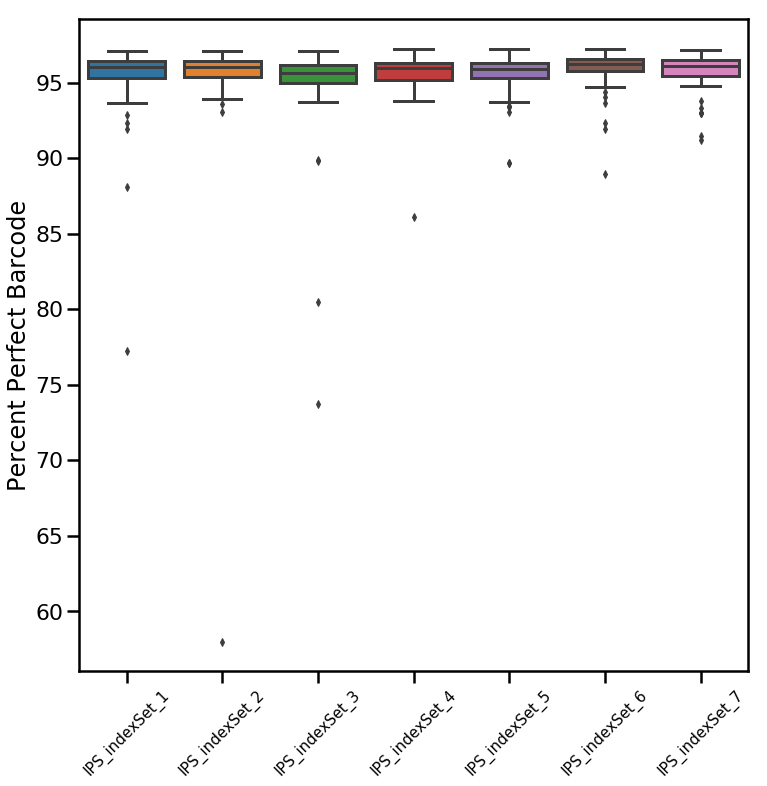

In [29]:
'''Box plot: Percent Perfect Barcode'''
df_merge_bc['plate_hiseq'] = df_merge_bc['plate_hiseq'].str.replace('IPS_CLN_RCSET','IPS_indexSet_').str.replace('a','').str.replace('b','')

plt.figure(figsize=(12, 12))
sns.set_context("poster")
ax = sns.boxplot(x='plate_hiseq', y=df_merge_bc.hiseq_avg_pct_perfect_bc*100, data=df_merge_bc.sort_values(by='plate_hiseq'))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45, fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Percent Perfect Barcode')

ax.figure.savefig("/Users/rchin/Downloads/PerfectBC_box_4.24.png", bbox_inches = 'tight')


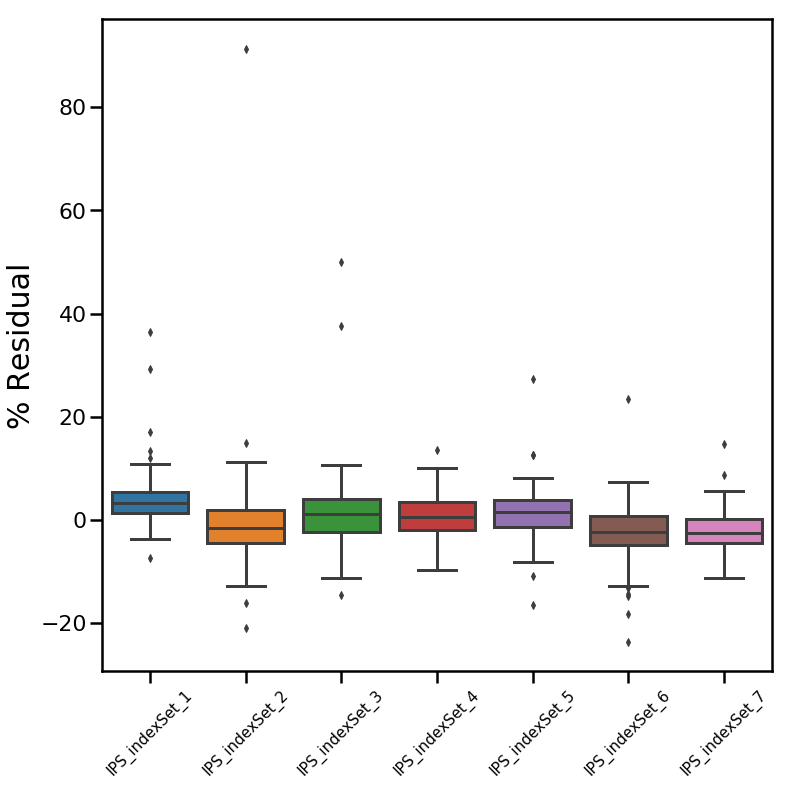

In [30]:
'''Box plot: Percent Residual'''
df_merge_bc['plate_hiseq'] = df_merge_bc['plate_hiseq'].str.replace('IPS_CLN_RCSET','IPS_indexSet_').str.replace('a','').str.replace('b','')

plt.figure(figsize=(12, 12))
sns.set_context("poster")
ax = sns.boxplot(x='plate_hiseq', y=df_merge_bc.pct_residual*100, data=df_merge_bc.sort_values(by='plate_hiseq'))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=45, fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('% Residual',fontsize=30)

ax.figure.savefig("/Users/rchin/Downloads/Residual_box_4.24.png", bbox_inches = 'tight')
              

In [31]:
# Calculate number of barcodes that meet certain pct perfect barcode criteria
print(len(df_merge_bc_summary[df_merge_bc_summary.hiseq_avg_pct_perfect_bc > 0.9])/len(df_merge_bc_summary))
print (len(df_merge_bc_summary[df_merge_bc_summary.hiseq_avg_pct_perfect_bc > 0.9]))

0.9834586466165414
654


In [32]:
# correlation between 1 barcode mismatch and total_mapped_reads_iseq
display(linregress_all_metrics(df_merge_bc.sort_values(by='hiseq_avg_pct_one_mismatch_bc', ascending=False).head(10),
                               'hiseq_avg_pct_one_mismatch_bc',
                               ['total_mapped_reads_hiseq', 'total_mapped_reads_iseq']))

,slope,intercept,r_value,p_value,std_err,comparison,metric,r_squared
0,4.647418e-05,0.003490,0.288053,0.419615,5.462410e-05,hiseq_avg_pct_one_mismatch_bc,total_mapped_reads_iseq,0.082975
1,-1.272077e-07,0.460618,-0.552390,0.097758,6.786924e-08,hiseq_avg_pct_one_mismatch_bc,total_mapped_reads_hiseq,0.305135


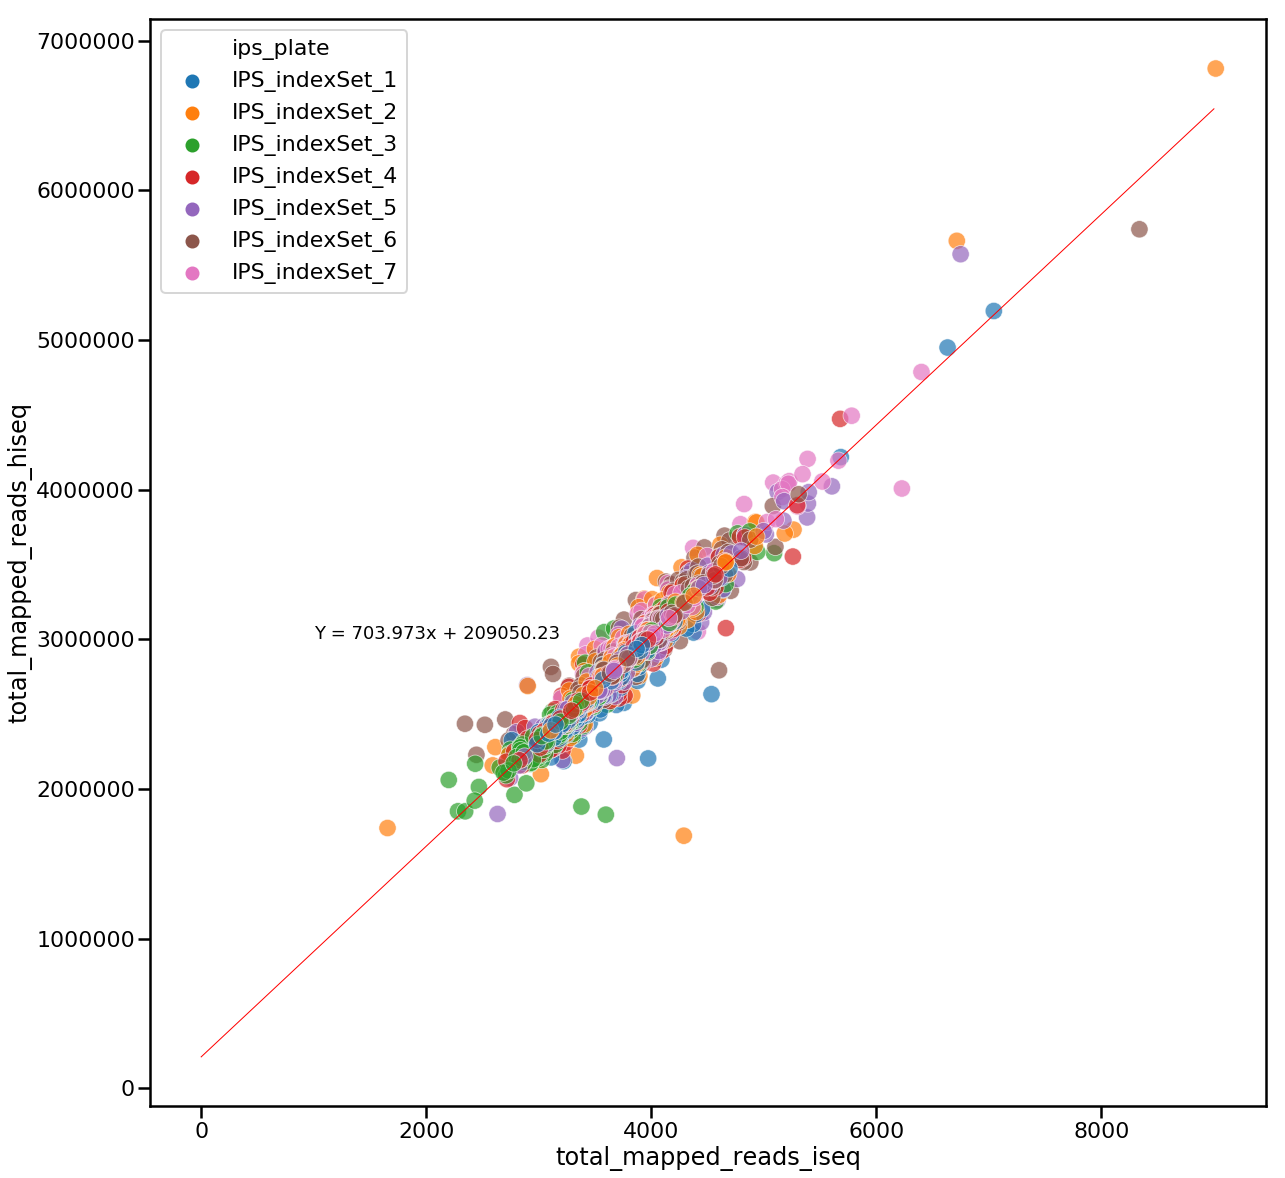

In [91]:
# Plot scatterplot with hue for primer set
#replace plate_coor names with ips_index
df_merge_bc['ips_plate'] = df_merge_bc['plate_hiseq'].str.replace('IPS_CLN_RCSET','IPS_indexSet_').str.replace('a','').str.replace('b','')
plate_order=['IPS_indexSet_1','IPS_indexSet_2', 'IPS_indexSet_3', 'IPS_indexSet_4', 'IPS_indexSet_5',
            'IPS_indexSet_6', 'IPS_indexSet_7']

plt.figure(figsize=(20, 20))
sns.set_context("poster")
scat = sns.scatterplot(data=df_merge_bc, x='total_mapped_reads_iseq', y='total_mapped_reads_hiseq',
                       hue='ips_plate', alpha=.7, s=300, hue_order=plate_order)

line = slope * 9000 + intercept
plt.plot([0,9000],[intercept,line], 'r-', linewidth=1)

equation = 'Y = ' + str('{0:.6g}'.format(slope)) + 'x + ' + str('{0:.8g}'.format(intercept))
plt.text(1000,3000000,equation, label='trendline', fontsize=18)


plt.show()

#save figure
# figure = scat.get_figure()
# figure.savefig("/Users/rchin/Downloads/hiseq_iseq_scatter_4.30s.png", bbox_inches = 'tight')


In [35]:
# evaluate variance among samples with low abs pct residual (<5%)
df_lowresid = df_merge_bc[df_merge_bc['abs_pct_residual'] <= 0.05]
print (len(df_lowresid))

cv_m = stats.variation(df_lowresid.total_mapped_reads_hiseq)
cv_a = stats.variation(df_merge_bc.total_mapped_reads_hiseq)
print ("mapped_reads (<5% resid) CV =", cv_m, 'mapped_reads all CV = ', cv_a )

lr_mean = df_lowresid.total_mapped_reads_hiseq.mean()
lf_sd = df_lowresid.total_mapped_reads_hiseq.std()
print ('mean =', lr_mean, 'sd = ', lf_sd)

485
mapped_reads (<5% resid) CV = 0.1809305792027682 mapped_reads all CV =  0.1906440514026765
mean = 2946181.5711340206 sd =  533604.7299243108


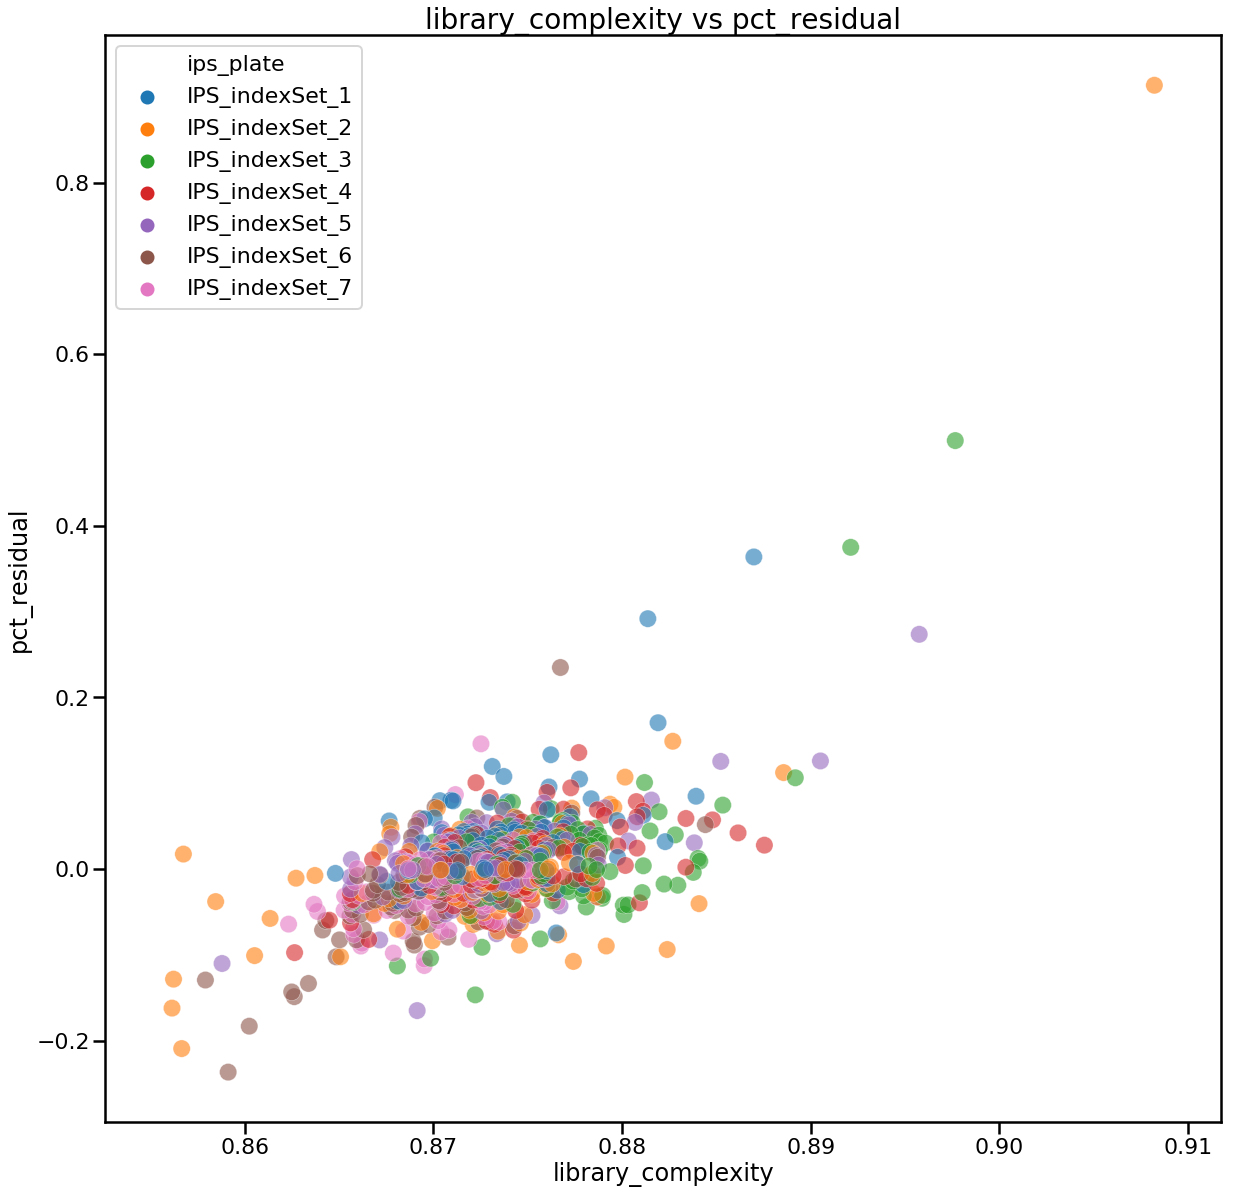

In [147]:
# scatter plot of <QC_metric>_hiseq (ie. total_mapped_reads_hiseq) vs library_complexity_hiseq

#Metrics: 'library_complexity', 'Q30', 'max_contamination', 'Q20', 'contamination',
# 'total_contamination', 'reads_aligned_at_duped_pos', 'proximal_dup_rate', 'unmapped_freq', 'mapped_freq'
metric = 'library_complexity'
y_metric = 'pct_residual'  #y_metrics: 'pct_residual', 'hiseq_avg_pct_perfect_bc'

plt.figure(figsize=(20, 20))
sns.set_context("poster")


scat = sns.scatterplot(data=df_merge_bc, x=metric+'_hiseq', y=y_metric, 
                       hue='ips_plate', alpha=0.6, linewidth=0.5, s=300, hue_order=plate_order)

scat.set_title('{} vs {}'.format(metric, y_metric), fontsize=28)
scat.set_xlabel(metric, fontsize=24)
scat.set_ylabel(y_metric, fontsize=24)

plt.show()

#save figure
figure = scat.get_figure()
figure.savefig("/Users/rchin/Downloads/hiseq_iseq_{}_5.8.png".format(metric), bbox_inches = 'tight')


In [85]:
# Add columns to calculate change in number of iseq reads to repair hiseq read residual.

# print(slope, intercept)
total_mapped_reads_iseq = df_merge_bc['total_mapped_reads_iseq']
# calculate expected mapped reads for a given data point
total_mapped_reads_expected = pd.Series(total_mapped_reads_iseq * slope + intercept)

# calculate y-intercept for observed data point with given linear regression slope
obs_intercept = df_merge_bc['total_mapped_reads_hiseq'] - (total_mapped_reads_iseq * slope)

# 
iseq_mapped_reads_for_repair = (total_mapped_reads_expected - obs_intercept) / slope

change_iseq_reads = iseq_mapped_reads_for_repair / total_mapped_reads_iseq

pct_change_iseq_reads = (pd.Series(["{0:.2f}%".format(val * 100) for val in change_iseq_reads],
                 index = change_iseq_reads.index))

diff_iseq_reads_repair = iseq_mapped_reads_for_repair - total_mapped_reads_iseq

# print (pct_change_iseq_reads)
# print (diff_iseq_reads_repair)

df_merge_bc['iseq_mapped_reads_for_repair'] = iseq_mapped_reads_for_repair
df_merge_bc['diff_iseq_reads_repair'] = diff_iseq_reads_repair
df_merge_bc['pct_change_iseq_reads_for_repair'] = pct_change_iseq_reads

# export df_merge_bc and 
bc_summary1 = ['index', 'barcode', 'plate_coor', 'plate_hiseq', 'coor_hiseq', 'residual', 'abs_residual', 'pct_residual', 
           'abs_pct_residual', 'hiseq_avg_pct_perfect_bc', 'hiseq_avg_pct_one_mismatch_bc','iseq_avg_pct_perfect_bc',
             'iseq_avg_pct_one_mismatch_bc', 'diff_iseq_reads_repair', 'pct_change_iseq_reads_for_repair' ]
df_merge_summary1 = df_merge_bc[bc_summary1]

display(df_merge_summary1.head(20))
df_merge_bc.to_csv("/Users/rchin/Downloads/iseq_hiseq_merge_bc_5.8.csv")
df_merge_summary1.to_csv("/Users/rchin/Downloads/iseq_hiseq_bc_summary_5.8.csv")


,index,barcode,plate_coor,plate_hiseq,coor_hiseq,residual,abs_residual,pct_residual,abs_pct_residual,hiseq_avg_pct_perfect_bc,hiseq_avg_pct_one_mismatch_bc,iseq_avg_pct_perfect_bc,iseq_avg_pct_one_mismatch_bc,diff_iseq_reads_repair,pct_change_iseq_reads_for_repair
0,116,AGAAGTCT,IPS_indexSet_2_B10,IPS_indexSet_2,B10,-1.541255e+06,1.541255e+06,0.913535,0.913535,0.579912,0.420088,1.0,NaN,2189.367879,151.05%
1,204,AGAATCGG,IPS_indexSet_3_B01,IPS_indexSet_3,B01,-9.128022e+05,9.128022e+05,0.499417,0.499417,0.737025,0.262975,1.0,NaN,1296.644235,136.06%
2,208,AGATAGGC,IPS_indexSet_3_B05,IPS_indexSet_3,B05,-7.057571e+05,7.057571e+05,0.375000,0.375000,0.805088,0.194913,1.0,NaN,1002.534715,129.67%
3,37,CCTCCGAG,IPS_indexSet_1_D02,IPS_indexSet_1,D02,-8.016849e+05,8.016849e+05,0.363816,0.363816,0.772663,0.227337,1.0,NaN,1138.801119,128.67%
4,25,CAGCCGGC,IPS_indexSet_1_C02,IPS_indexSet_1,C02,-7.684736e+05,7.684736e+05,0.291852,0.291852,0.938412,0.061587,1.0,NaN,1091.624081,124.07%
5,472,TCCGCGCA,IPS_indexSet_5_H05,IPS_indexSet_5,H05,-6.036065e+05,6.036065e+05,0.273630,0.273630,0.897125,0.102875,1.0,NaN,857.428829,123.21%
6,487,CAATACCA,IPS_indexSet_6_A08,IPS_indexSet_6,A08,5.763437e+05,5.763437e+05,-0.236642,0.236642,0.959175,0.040825,1.0,NaN,-818.701698,65.07%
7,528,GAGATCTT,IPS_indexSet_6_D12,IPS_indexSet_6,D12,-6.561278e+05,6.561278e+05,0.234952,0.234952,0.889363,0.110637,1.0,NaN,932.035760,120.25%
8,105,ACCGCCGA,IPS_indexSet_2_A11,IPS_indexSet_2,A11,3.636769e+05,3.636769e+05,-0.209189,0.209189,0.958175,0.041825,1.0,NaN,-516.606538,68.80%
9,484,ATGGCGAG,IPS_indexSet_6_A05,IPS_indexSet_6,A05,4.446635e+05,4.446635e+05,-0.183107,0.183107,0.953900,0.046100,1.0,NaN,-631.648752,74.94%


In [180]:
# Repair barcodes for top-20 most divergent barcodes by calculating how many more/less iseq reads to get
# the expected amount of hiseq reads, based on SLOPE for that observed sample.  Keep same Y-intercept.

# print(slope, intercept)
total_mapped_reads_iseq = df_merge_bc['total_mapped_reads_iseq']  # X-value (iseq reads)
# calculate expected mapped reads for a given data point
total_mapped_reads_expected = pd.Series(total_mapped_reads_iseq * slope + intercept)

# calculate observed slope for each data point with given linear regression y-intercept
obs_slope =  (df_merge_bc['total_mapped_reads_hiseq'] - intercept) / total_mapped_reads_iseq

# y = m*x + b

# Calculate reads needed for repair
iseq_reads_repair = (total_mapped_reads_expected - intercept) / obs_slope

change_iseq_reads = iseq_reads_repair / total_mapped_reads_iseq

pct_change_iseq_reads = (pd.Series(["{0:.2f}%".format(val * 100) for val in change_iseq_reads],
                 index = change_iseq_reads.index))

diff_iseq_reads_repair = iseq_reads_repair - total_mapped_reads_iseq

# print (pct_change_iseq_reads)
# print (diff_iseq_reads_repair)

df_merge_bc['iseq_reads_repair'] = iseq_reads_repair
df_merge_bc['total_mapped_reads_expected'] = total_mapped_reads_expected
df_merge_bc['diff_iseq_reads_repair'] = diff_iseq_reads_repair
df_merge_bc['pct_change_iseq_reads_for_repair'] = pct_change_iseq_reads


# export df_merge_bc and 
bc_summary1 = ['index', 'barcode', 'plate_coor', 'plate_hiseq', 'coor_hiseq', 'residual', 'abs_residual', 'pct_residual', 
           'abs_pct_residual', 'hiseq_avg_pct_perfect_bc', 'hiseq_avg_pct_one_mismatch_bc','iseq_avg_pct_perfect_bc',
             'iseq_avg_pct_one_mismatch_bc', 'total_mapped_reads_iseq', 'iseq_reads_repair', 'diff_iseq_reads_repair', 'pct_change_iseq_reads_for_repair' ]

bc_summary2 = ['barcode', 'plate_hiseq', 'coor_hiseq', 'total_mapped_reads_hiseq', 'total_mapped_reads_expected', 
               'pct_residual', 'total_mapped_reads_iseq', 'iseq_reads_repair', 'diff_iseq_reads_repair', 
               'pct_change_iseq_reads_for_repair' ]

df_merge_summary2 = df_merge_bc[bc_summary2]

display(df_merge_summary2.head(50))

# Export to csv
df_merge_summary2.to_csv("/Users/rchin/Downloads/iseq_hiseq_repair_5.15.csv")


,barcode,plate_hiseq,coor_hiseq,total_mapped_reads_hiseq,total_mapped_reads_expected,pct_residual,total_mapped_reads_iseq,iseq_reads_repair,diff_iseq_reads_repair,pct_change_iseq_reads_for_repair
0,AGAAGTCT,IPS_indexSet_2,B10,1687134,3.228389e+06,0.913535,4289,8761.306714,4472.306714,204.27%
1,AGAATCGG,IPS_indexSet_3,B01,1827734,2.740536e+06,0.499417,3596,5623.843078,2027.843078,156.39%
2,AGATAGGC,IPS_indexSet_3,B05,1882017,2.587774e+06,0.375000,3379,4804.463618,1425.463618,142.19%
3,CCTCCGAG,IPS_indexSet_1,D02,2203545,3.005230e+06,0.363816,3972,5568.540954,1596.540954,140.19%
4,CAGCCGGC,IPS_indexSet_1,C02,2633093,3.401567e+06,0.291852,4535,5972.692346,1437.692346,131.70%
5,TCCGCGCA,IPS_indexSet_5,H05,2205919,2.809526e+06,0.273630,3694,4810.609422,1116.609422,130.23%
6,CAATACCA,IPS_indexSet_6,A08,2435506,1.859162e+06,-0.236642,2344,1737.228650,-606.771350,74.11%
7,GAGATCTT,IPS_indexSet_6,D12,2792605,3.448733e+06,0.234952,4602,5770.738519,1168.738519,125.40%
8,ACCGCCGA,IPS_indexSet_2,A11,1738506,1.374829e+06,-0.209189,1656,1262.233153,-393.766847,76.22%
9,ATGGCGAG,IPS_indexSet_6,A05,2428429,1.983765e+06,-0.183107,2521,2015.905196,-505.094804,79.96%
